# Developing an AI application

In this project, I'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. I'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

In [4]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import time
import shutil
import torch
#import helper
import torchvision
from torch import nn
from torch import optim
import numpy as np
from PIL import Image
import torch.nn.functional as F
from collections import OrderedDict
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

## Load the data

Here I'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data can be [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

You can download it using the following commands. 

```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, I'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks I used were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets there's the need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [5]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

## Define your transforms for the training, validation, and testing sets

In [6]:
# Define your transforms for the training, validation, and testing sets

#training set
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

# validation set
valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ])

# testing set
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]) 


# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms) # cost


# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)


# Verify the datasets are loaded correctly, and print some information about them
print(f"Number of training images: {len(train_data)}")
print(f"Number of validation images: {len(valid_data)}")
print(f"Number of testing images: {len(test_data)}")


Number of training images: 6552
Number of validation images: 818
Number of testing images: 819


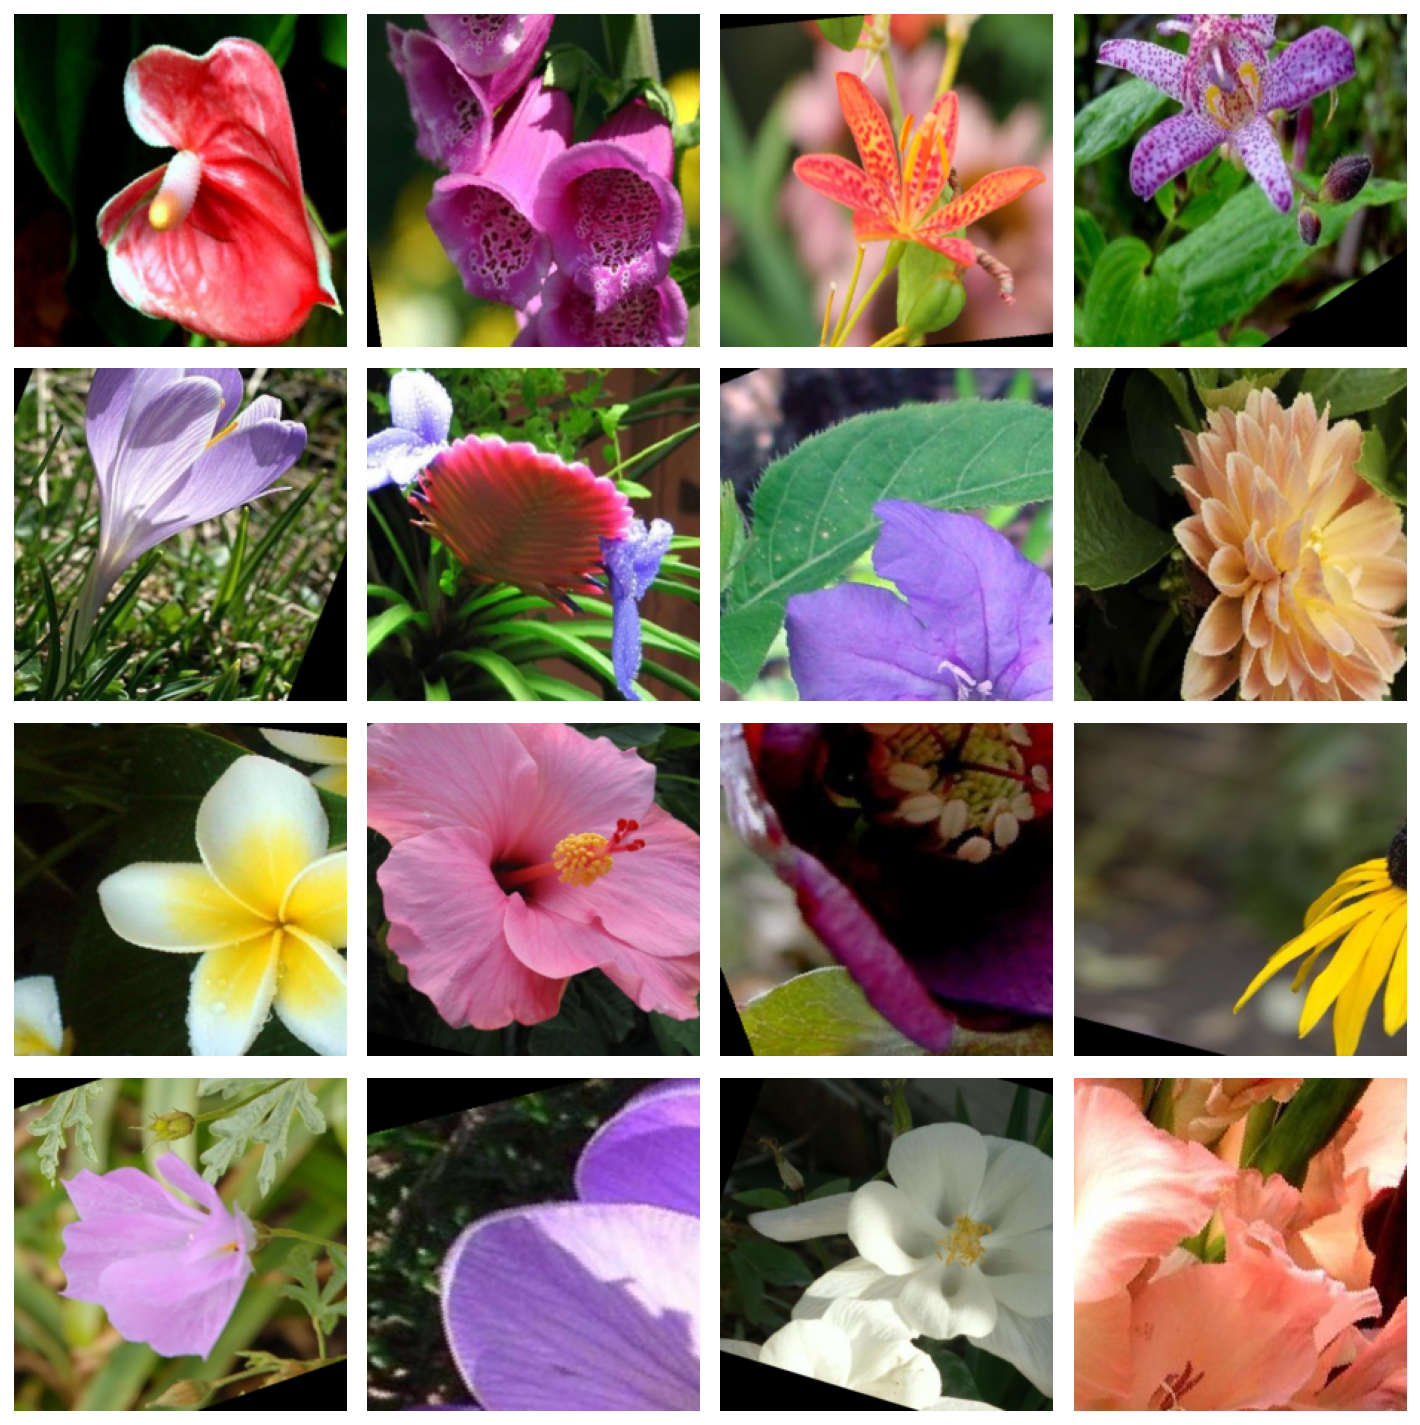

In [7]:

import numpy as np

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    if title:
        ax.set_title(title)
    ax.axis('off')
    return ax

# Get a batch of training data
images, labels = next(iter(trainloader))

# Display the images
fig, axes = plt.subplots(figsize=(10, 10), nrows=4, ncols=4)
for i in range(16):
    ax = axes[i // 4, i % 4]
    imshow(images[i], ax=ax)
plt.tight_layout()
plt.show()


### Label mapping

I'll also need to load in a mapping from category label to category name. The file `cat_to_name.json` is a JSON object which can be read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [8]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

## Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.


* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (The VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

I'll be updating only the weights of the feed-forward network. I am expecting the validation accuracy above 70%, all things being equal. I try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. 

## Load a pre-trained network

In [10]:
# defines number of hidden units
hidden_units = 4096

model = models.vgg16_bn(pretrained=True)

# the weights of the pretrained model are frozen to avoid backpropping through them
for param in model.parameters():
    param.requires_grad = False

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [11]:
no_output_categories = len(cat_to_name)

# Defines the classifier
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(0.05)),
                          ('fc2', nn.Linear(4096, no_output_categories)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replace the pretrained classifier with the one created above
model.classifier = classifier

model.classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.05, inplace=False)
  (fc2): Linear(in_features=4096, out_features=102, bias=True)
  (output): LogSoftmax(dim=1)
)

In [12]:
#initializing criterion and optimizer
criterion = nn.NLLLoss ()
optimizer = optim.Adam (model.classifier.parameters (), lr = 0.001)

## Train the model

In [13]:
# set device to either cuda or gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f'The device in use is {device}.\n')

# set the training hyperparameters
epochs = 10 
optimizer = optim.Adam(model.classifier.parameters(),lr=.001) # makes use of momentum to avoid local minima
criterion = nn.NLLLoss() 

print_every = 20 
running_loss = running_accuracy = 0
validation_losses, training_losses = [],[]

# define the training process
for e in range(epochs):
    batches = 0 

    # turn on training mode
    model.train()

    for images,labels in trainloader:

        batches += 1

        # move images and labels to the GPU
        images,labels = images.to(device),labels.to(device)

        # pushe batch through network
        log_ps = model.forward(images)
        loss = criterion(log_ps,labels)
        loss.backward()
        optimizer.step()

        # calculate the metrics
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1,dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
        accuracy = matches.mean()

        # reset optimiser gradient and track metrics
        optimizer.zero_grad()
        running_loss += loss.item()
        running_accuracy += accuracy.item()

        # runs the model on the validation set every 5 loops
        if batches%print_every == 0:

            # set the metrics
            validation_loss = 0
            validation_accuracy = 0

            # turn on evaluation mode, turn off calculation of gradients
            model.eval()
            with torch.no_grad():
                for images,labels in validloader:
                    images,labels = images.to(device),labels.to(device)
                    log_ps = model.forward(images)
                    loss = criterion(log_ps,labels)
                    ps = torch.exp(log_ps)
                    top_ps, top_class = ps.topk(1,dim=1)
                    matches = (top_class == \
                                labels.view(*top_class.shape)).type(torch.FloatTensor)
                    accuracy = matches.mean()

                    # track validation metrics (test of the model's progress)
                    validation_loss += loss.item()
                    validation_accuracy += accuracy.item()
                
            # track training metrics

            validation_losses.append(running_loss/print_every)
            training_losses.append(validation_loss/len(validloader))
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Valid Loss: {:.3f}.. ".format(validation_loss/len(validloader)),
                  "Valid Accuracy: {:.3f}%".format(validation_accuracy/len(validloader)*100))
            
            # reset the metrics and turn on training mode
            running_loss = running_accuracy = 0
            model.train()    

The device in use is cuda:0.

Epoch: 1/10..  Training Loss: 5.058..  Valid Loss: 3.189..  Valid Accuracy: 30.529%
Epoch: 1/10..  Training Loss: 2.902..  Valid Loss: 1.667..  Valid Accuracy: 62.607%
Epoch: 1/10..  Training Loss: 1.829..  Valid Loss: 1.074..  Valid Accuracy: 70.045%
Epoch: 1/10..  Training Loss: 1.480..  Valid Loss: 0.805..  Valid Accuracy: 75.334%
Epoch: 1/10..  Training Loss: 1.243..  Valid Loss: 0.672..  Valid Accuracy: 81.517%
Epoch: 2/10..  Training Loss: 1.204..  Valid Loss: 0.512..  Valid Accuracy: 85.964%
Epoch: 2/10..  Training Loss: 0.907..  Valid Loss: 0.560..  Valid Accuracy: 84.642%
Epoch: 2/10..  Training Loss: 0.834..  Valid Loss: 0.460..  Valid Accuracy: 88.007%
Epoch: 2/10..  Training Loss: 0.784..  Valid Loss: 0.410..  Valid Accuracy: 89.209%
Epoch: 2/10..  Training Loss: 0.791..  Valid Loss: 0.432..  Valid Accuracy: 89.330%
Epoch: 3/10..  Training Loss: 0.795..  Valid Loss: 0.408..  Valid Accuracy: 89.570%
Epoch: 3/10..  Training Loss: 0.665..  Valid L

In [14]:
print("Valid Accuracy: {:.3f}%".format(validation_accuracy/len(validloader)*100))

Valid Accuracy: 93.536%


## Testing the network

It's good practice to test the trained network on test data, images the network has never seen either in training or validation. This will give a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way I did validation.

## Validation on the test set

In [15]:
# define test accuracy
test_accuracy = 0

# define start time
start_time = time.time()
print('Validation started.')

# define tests
for images,labels in testloader:
    model.eval()
    images,labels = images.to(device),labels.to(device)
    log_ps = model.forward(images)
    ps = torch.exp(log_ps)
    top_ps,top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    test_accuracy += accuracy
    
# print metrics
print(f'Test Accuracy: {test_accuracy/len(testloader)*100:.2f}%')

Validation started.
Test Accuracy: 91.50%


## Save the checkpoint

Now that the network is trained, I'll have to save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. I make sure I included the information I'll need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [16]:
# save the checkpoint 

hidden_units = 4096

# save the checkpoint in the current directory
destination_directory = None
class_to_idx = train_data.class_to_idx # improves label to name mapping

# save the model's state_dict
def save_model(trained_model,hidden_units,output_units,destination_directory,model_arch,class_to_idx):
    # define model's checkpoint
    model_checkpoint = {'model_arch':model_arch, 
                    'clf_input':25088,
                    'clf_output':output_units,
                    'clf_hidden':hidden_units,
                    'state_dict':trained_model.state_dict(),
                    'model_class_to_index':class_to_idx,
                    }
    
    # save model in current directory
    if destination_directory:
        torch.save(model_checkpoint,destination_directory+"/"+model_arch+"_checkpoint.pth")
        print(f"{model_arch} successfully saved to {destination_directory}")
    else:
        torch.save(model_checkpoint,model_arch+"_checkpoint.pth")
        print(f"{model_arch} successfully saved to current directory as {model_arch}_checkpoint.pth")

# call save_model
save_model(model,hidden_units,no_output_categories,destination_directory,'vgg16_bn',class_to_idx)

vgg16_bn successfully saved to current directory as vgg16_bn_checkpoint.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

## Write a function that loads a checkpoint and rebuilds the model

In [17]:
# define checkpoint as file created above
checkpoint = 'vgg16_bn_checkpoint.pth'

# function that accepts two arguments: filepath (location of checkpoint) and device(gpu/cpu)
def load_checkpoint(filepath,device):
    # load the GPU when available
    if device=="gpu":
        map_location=lambda device, loc: device.cuda()
    else:
        map_location='cpu'
        # redefine checkpoint
    checkpoint = torch.load(f=filepath,map_location=map_location)

    # function returns number of input units, output units, hidden units, and state_dict
    return checkpoint['model_arch'],checkpoint['clf_input'], checkpoint['clf_output'], checkpoint['clf_hidden'],checkpoint['state_dict'],checkpoint['model_class_to_index']

# load the checkpoint
model_arch,input_units, output_units, hidden_units, state_dict, class_to_idx = load_checkpoint(checkpoint,device)
model.load_state_dict(state_dict)

<All keys matched successfully>

# Inference for classification

Now I'll write a function to use a trained network for inference. That is, I'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First I'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

I'll use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. I'll subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. I'll reorder the dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [18]:
# define the location of the image to preprocess
practice_img = './flowers/test/19/image_06186.jpg'

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a Numpy array
    '''
    #Process a PIL image for use in a PyTorch model
    
    # Load the image
    processed_image = Image.open(image).convert('RGB')
    # resizes image
    processed_image.thumbnail(size=(256,256)) # keeps aspect ratio
    width, height = processed_image.size # gets image dimensions

    # set new dimensions for center crop
    new_width,new_height = 224,224 
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    processed_image = processed_image.crop((left, top, right, bottom))

    # convert to tensor adn normalises
    transf_tens = transforms.ToTensor()
    transf_norm = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    tensor = transf_norm(transf_tens(processed_image))
    
    # convert tensor result to numpy array
    np_processed_image = np.array(tensor)
    return np_processed_image


    

To check my work, the function below converts a PyTorch tensor and displays it in the notebook. If the `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [19]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Display original image

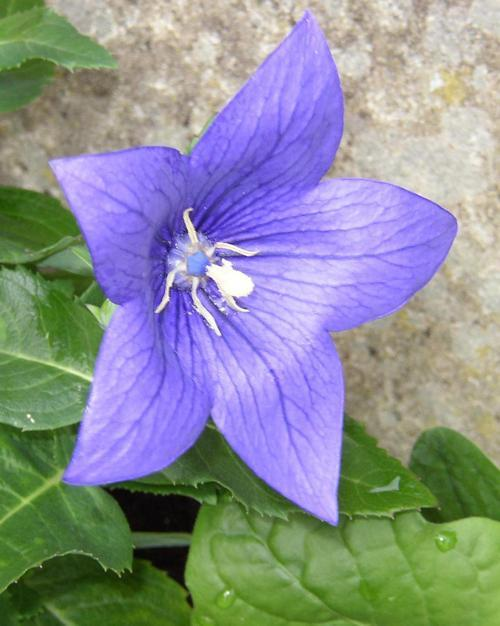

In [20]:
processed_image = Image.open(practice_img)
processed_image

<Axes: >

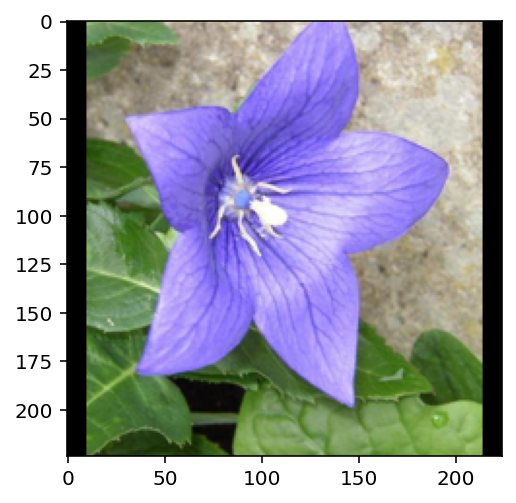

In [21]:
# display preprocessed image
imshow(process_image(practice_img))

## Class Prediction

Once we have the images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You'll need to convert from these indices to the actual class labels using `class_to_idx` which was added to the model or from an `ImageFolder` used to load the data ([see here](#Save-the-checkpoint)).

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

## Implement the code to predict the class from an image file

In [22]:


file = 'cat_to_name.json'

# takes .json file and converts it into a dictionary
def class_to_label(file,classes):
    with open(file, 'r') as f:
        class_mapping =  json.load(f)
        
    labels = []
    for c in classes:
        labels.append(class_mapping[c])
    return labels

# usies class_to_label() to map folder labels (1-102) to flower names
idx_mapping = dict(map(reversed, class_to_idx.items()))

# predicts the class of an image using out deep learning model
# mapping is the dictionary mapping indices to classes
def predict(image_path, model,idx_mapping, topk, device):
    # defines preprocessed image
    pre_processed_image = torch.from_numpy(process_image(image_path))
    pre_processed_image = torch.unsqueeze(pre_processed_image,0).to(device).float()
    
    model.to(device)
    model.eval()
    
    log_ps = model.forward(pre_processed_image)
    ps = torch.exp(log_ps)
    top_ps,top_idx = ps.topk(topk,dim=1)
    list_ps = top_ps.tolist()[0]
    list_idx = top_idx.tolist()[0]
    classes = []
    model.train()
    
    for x in list_idx:
        classes.append(idx_mapping[x])
    return list_ps, classes

# prints the probability output
def print_predictions(probabilities, classes,image,category_names=None):
    # prints out the image
    print(image)
    
    if category_names:
        labels = class_to_label(category_names,classes)
        for i,(ps,ls,cs) in enumerate(zip(probabilities,labels,classes),1):
            print(f'{i}) {ps*100:.2f}% {ls.title()} | Class No. {cs}')
    else:
        for i,(ps,cs) in enumerate(zip(probabilities,classes),1):
            print(f'{i}) {ps*100:.2f}% Class No. {cs} ')
    print('') 

probabilities,classes = predict(practice_img,model,idx_mapping,5,device)

# prints out the predictions
print_predictions(probabilities,classes,practice_img.split('/')[-1],file)

image_06186.jpg
1) 99.97% Balloon Flower | Class No. 19
2) 0.02% Petunia | Class No. 51
3) 0.01% Clematis | Class No. 82
4) 0.00% Passion Flower | Class No. 77
5) 0.00% Wild Pansy | Class No. 52



## Sanity Checking

Now that I can use a trained model for predictions, I'll check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

I'll convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, I'll use the `imshow` function defined above.

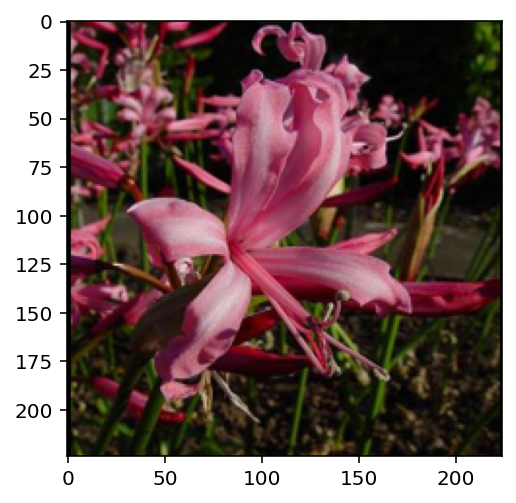

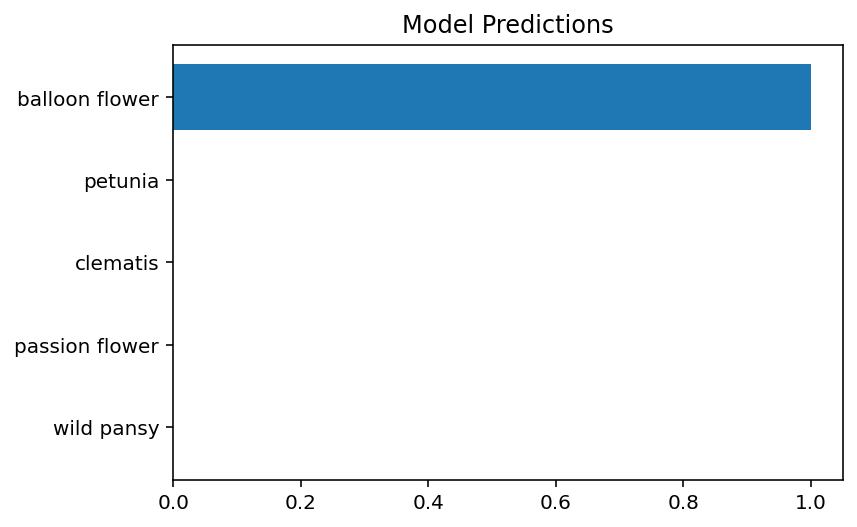

In [28]:
# Define image path
img_path = "flowers/test/37/image_03734.jpg"

# display an image along with the top 5 classes
imshow(process_image(img_path))

# uses matplotlib for the task
plt.figure() 

# define probability axis
plt.barh(class_to_label(file,classes),width=probabilities)
plt.title('Model Predictions') 
plt.gca().invert_yaxis() 
plt.show() 


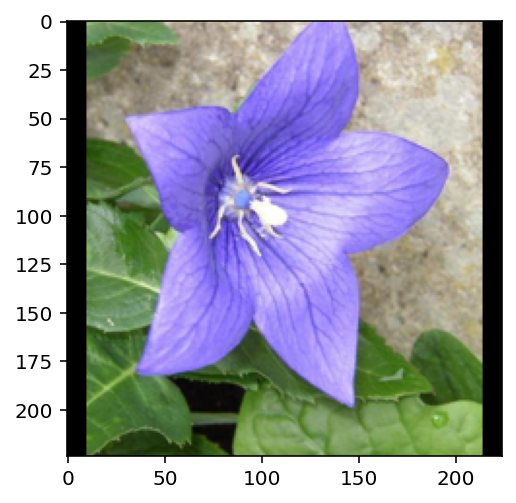

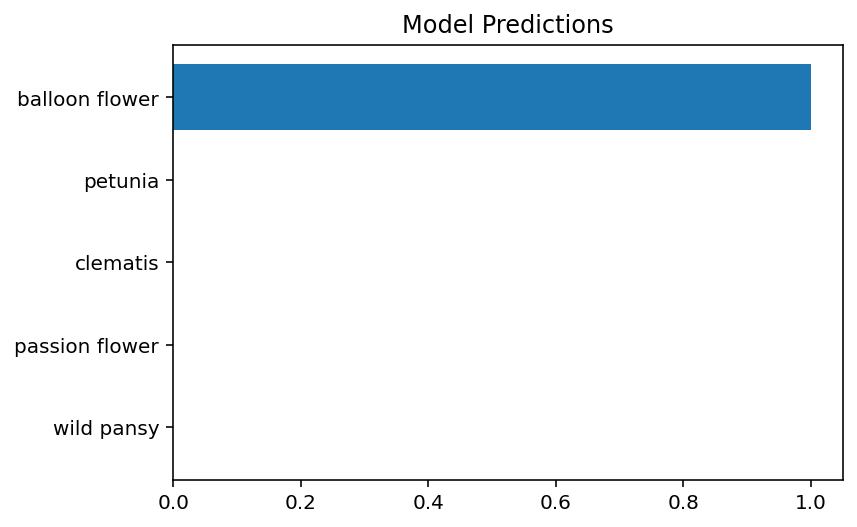

In [23]:
# Displays an image along with the top 5 classes

imshow(process_image(practice_img))

# use matplotlib for the task
plt.figure() 

# define probability axis
plt.barh(class_to_label(file,classes),width=probabilities)
plt.title('Model Predictions') 
plt.gca().invert_yaxis() 
plt.show() 
